In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from src.model_specpred import SpectrumPredictor
from src.utils_model import lorentzian, spec_to_Sqt, batch_spec_to_Sqt

from scipy.interpolate import interp1d
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

torch.set_default_dtype(torch.float64)

c:\Users\zhantao\.conda\envs\quspin\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


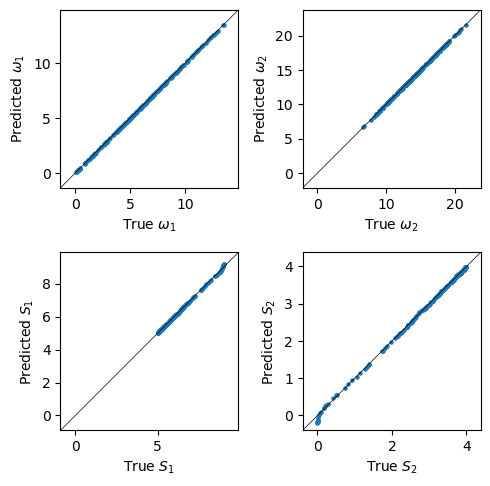

In [2]:
data = torch.load("data/CrI3/20221110.pt")
X = data['param'][:,:2]
Y = torch.cat((data['omega'], data['inten']), dim=1)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=1/5, random_state=42)

train_dataset = TensorDataset(X_train, Y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

model_spec = SpectrumPredictor.load_from_checkpoint("training_logs/lightning_logs/version_39/checkpoints/epoch=3467-step=86700.ckpt")

Y_val_pred = []
with torch.no_grad():
    for x_val in X_val:
        Y_val_pred.append(model_spec(x_val).detach())
Y_val_pred = torch.vstack(Y_val_pred)

labels = ['$\omega_1$', '$\omega_2$', '$S_1$', '$S_2$']

fig = plt.figure(figsize=(5,5))
gs = plt.GridSpec(2,2)
for i in range(4):
    ax = fig.add_subplot(gs[i])
    ax.plot([-100,100], [-100,100], 'k', linewidth=0.5)
    ax.scatter(Y_val[:,i], Y_val_pred[:,i], s=5)
    ax.set_aspect('equal')
    ax.set_xlim([-0.1*Y_val[:,i].max(), 1.1*Y_val[:,i].max()])
    ax.set_ylim([-0.1*Y_val[:,i].max(), 1.1*Y_val[:,i].max()])
    ax.set_xlabel(f"True {labels[i]}")
    ax.set_ylabel(f"Predicted {labels[i]}")

fig.tight_layout()

In [3]:
import optbayesexpt as obe
from src.utils_model import construct_fc_net, batch_spec_to_Sqt, array2tensor, tensor2array

class BayesianInference(torch.nn.Module):
    NUM_SAMPLES_PER_STEP = 10
    def __init__(self, model, settings=(), parameters=(), constants=(), batch_size=500, scale_factor=1.):
        """_summary_

        Parameters
        ----------
        model : torch.nn.Module
        param_prior : dict
            {'p1': {'mu': 0., 'sigma': 1.}}
        settings : tuple/list of arrays/tensors
        """
        super().__init__()
        self.register_module('forward_model', model)
        self.settings = settings
        self.parameters = parameters
        self.constants= constants
        self.init_OptBayesExpt()

    def init_OptBayesExpt(self, ):
        self.obe_model = obe.OptBayesExpt(self.model_function, self.settings, self.parameters, self.constants)
        self.measured_settings = []
        self.measured_observables = []
        self.param_mean = []
        self.param_std = []

    def model_function(self, sets, pars, cons):
        """ Evaluates a trusted model of the experiment's output
        The equivalent of a fit function. The argument structure is
        required by OptBayesExpt.
        Args:
            sets: A tuple of setting values, or a tuple of settings arrays
            pars: A tuple of parameter arrays or a tuple of parameter values
            cons: A tuple of floats
        Returns:  the evaluated function
        """
        # unpack the settings
        # t, = sets
        # unpack model parameters
        t, = sets
        J, D, gamma = pars
        if isinstance(t, (int, float)):
            t = torch.tensor([t,])
        else:
            t = torch.atleast_1d(array2tensor(t))
        if isinstance(gamma, (int, float)):
            gamma = torch.atleast_2d(torch.tensor([gamma]))
        else:
            gamma = array2tensor(gamma)[:,None]

        if isinstance(J, (int, float)):
            J = torch.tensor([[J]])
            D = torch.tensor([[D]])
        else:
            J = array2tensor(J)[:,None]
            D = array2tensor(D)[:,None]

        x = torch.cat((J, D), dim=1)
        y = self.forward_model(x.to(self.forward_model.device)).cpu()

        omega, inten = torch.split(y, (y.shape[1]//2, y.shape[1]//2), dim=1)
        S_envelope = torch.exp(-torch.einsum("bm,t->bmt", F.relu(gamma), t))
        S_pred = (batch_spec_to_Sqt(omega, inten, t) * S_envelope).sum(dim=1)
        # S_pred = S_pred / batch_spec_to_Sqt(omega, inten, torch.tensor([0,])).sum(dim=1)
        # calculate the Lorentzian
        return S_pred.detach().cpu().squeeze().numpy()

    def step_OptBayesExpt(self, func_measure):

        next_setting = self.obe_model.opt_setting()
        next_observable = func_measure.simdata(next_setting)

        measurement = (next_setting, next_observable, func_measure.noise_level)
        self.obe_model.pdf_update(measurement)

        self.measured_settings.append(next_setting)
        self.measured_observables.append(next_observable)
        self.param_mean.append(self.obe_model.mean())
        self.param_std.append(self.obe_model.std())
        # pars = [np.random.normal(self.obe_model.mean()[i], self.obe_model.std()[i], NUM_SAMPLES_PER_STEP) for i in range(len(self.obe_model.mean()))]
        # est_S_lst.append(self.model_function(self.settings, pars, ()))

            # if np.all(param_std[-1] < 1e-2):
            #     break

    def run_N_steps_OptBayesExpt(self, N, func_measure):
        for i in range(N):
            self.step_OptBayesExpt(func_measure)
        
    def get_all_measurements(self,):
        settings = np.asarray(self.measured_settings)
        observables = np.asarray(self.measured_observables)
        return settings, observables

    def get_organized_measurements(self,):
        settings, observables = self.get_all_measurements()
        unique_settings  = []
        mean_observables = []
        std_observables  = []
        for setting in np.unique(settings):
            unique_settings.append(setting)
            idx = np.where(settings==setting)[0]
            mean_observables.append(observables[idx].mean())
            std_observables.append(observables[idx].std())
        unique_settings  = np.asarray(unique_settings)
        mean_observables = np.asarray(mean_observables)
        std_observables  = np.asarray(std_observables)
        return unique_settings, mean_observables, std_observables

    def run_gradient_desc_on_current_measurements(self, N, init_bayes_guess=False, batch_size=10):
        unique_settings, mean_observables, std_observables = \
            self.get_organized_measurements()
        t = torch.from_numpy(unique_settings).squeeze()
        S = torch.from_numpy(mean_observables).squeeze()
        if init_bayes_guess:
            loss_hist, params_hist = self.forward_model.fit_measurement_with_OptBayesExpt_parameters(
                t, S, (('J', 'D', 'gamma'), self.obe_model.mean(), self.obe_model.std()), 
                maxiter=N, batch_size=batch_size
            )
        else:
            loss_hist, params_hist = self.forward_model.fit_measurement_with_OptBayesExpt_parameters(
                t, S, (('J', 'D', 'gamma'), (-2.0, -0.5, 0.5), (0.5, 0.25, 0.25)), 
                maxiter=N, batch_size=batch_size
            )

    def predict_all_settings(self, ):
        measurements = self.model_function(self.settings, self.obe_model.mean(), ())
        return self.settings, measurements

    def measure_all_settings(self, func_measure):
        measurements = func_measure.simdata(self.settings)
        return self.settings, measurements
    
    def update_OptBayesExpt_particles(self,):
        particles = torch.cat([eval(f'bayes.forward_model.{name}.data').T for name in ('J', 'D', 'gamma')], dim=0).cpu().numpy()
        self.obe_model = obe.OptBayesExpt(self.model_function, self.settings, particles, self.constants)

In [4]:
times = np.arange(0,10,0.01)
settings = (times, )
parameters = (
    np.random.uniform(-2.5, 0.0, 1001),
    np.random.uniform(-1.0,-0.0, 1001),
    np.random.uniform( 0.0, 1.0, 1001)
    )

In [5]:

idx = np.random.choice(len(X_val))
idx = 103
print(idx)
x_val = X_val[idx]
y_val = Y_val[idx]
linewidth = 0.25
noise_level = 1.0

omega_val, inten_val = [], []
for i in range(2):
    _omega, _inten = lorentzian(y_val[i], linewidth, y_val[i+2], minimum=0.)
    omega_val.append(_omega); inten_val.append(_inten)
omega_val = torch.cat(omega_val); inten_val = torch.cat(inten_val)
inten_val = inten_val / inten_val.sum() * y_val[-2:].sum()
true_pars = x_val.cpu().numpy().tolist() + [linewidth,]

print(x_val)
print(y_val)
print(model_spec(x_val))

time_val = torch.from_numpy(times)
# pred_S = model_function((time_val,), true_pars, ())
true_S = batch_spec_to_Sqt(omega_val, inten_val, time_val).sum(dim=1).squeeze()
# true_S = true_S / true_S[0]


from scipy.interpolate import interp1d
func_S = interp1d(time_val, true_S)
        
def model_function_true(sets, pars, cons):
    """ Evaluates a trusted model of the experiment's output
    The equivalent of a fit function. The argument structure is
    required by OptBayesExpt.
    Args:
        sets: A tuple of setting values, or a tuple of settings arrays
        pars: A tuple of parameter arrays or a tuple of parameter values
        cons: A tuple of floats
    Returns:  the evaluated function
    """
    # unpack the settings
    # t, = sets
    # unpack model parameters
    t, = sets
    if isinstance(t, (int, float)):
        t = np.array([t,])
    else:
        t = np.atleast_1d(tensor2array(t))
    
    S_pred = func_S(t)
    # calculate the Lorentzian
    return S_pred

obe_sim = obe.MeasurementSimulator(
    model_function_true, true_pars, (), noise_level=noise_level)
obe_sim_noisefree = obe.MeasurementSimulator(
    model_function_true, true_pars, (), noise_level=0.)

# true_S = model_function((time_val,), true_pars, ())
print(true_pars)

103
tensor([-2.9984, -0.0970])
tensor([13.4375, 15.8050,  7.9457,  1.0543])
tensor([13.4416, 15.8286,  7.9569,  1.0404], grad_fn=<SqueezeBackward3>)
[-2.9983827635880753, -0.09699355370427021, 0.25]


In [6]:
bayes = BayesianInference(model_spec, settings, parameters)

In [12]:
bayes.run_N_steps_OptBayesExpt(100, obe_sim)
print(bayes.obe_model.mean(), bayes.obe_model.std())
bayes.run_gradient_desc_on_current_measurements(100, batch_size=bayes.obe_model.n_particles, init_bayes_guess=False)

[-2.99127113 -0.0883902   0.18815131] [0.00495057 0.00482449 0.009601  ]


Iter   99 Loss 102.139399: 100%|██████████| 100/100 [00:01<00:00, 56.08it/s]


In [8]:
bayes.update_OptBayesExpt_particles()
print(bayes.obe_model.mean(), bayes.obe_model.std())

[-2.02833921 -0.49591292  0.54973921] [0.48866597 0.26272867 0.25586318]


In [13]:
param_mean = np.asarray(bayes.param_mean)
param_std = np.asarray(bayes.param_std)

In [14]:
measured_settings, measured_observables = bayes.get_all_measurements()
_, measurements_noisefree = bayes.measure_all_settings(obe_sim_noisefree)
_, measurements_predicted = bayes.predict_all_settings()

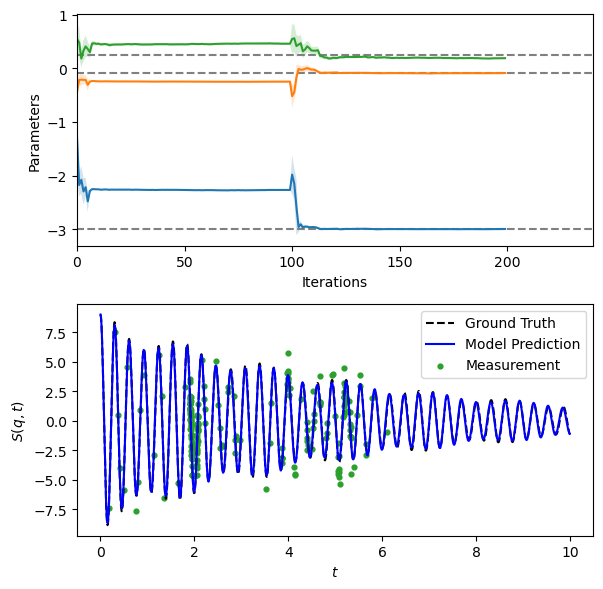

In [15]:
maxiter = len(param_mean)

label_lst = ["$J$", "$D$", "$\gamma$"]
fig, ax = plt.subplots(2,1,figsize=(6,6))
for i in range(param_mean.shape[1]):
    ax[0].fill_between(np.arange(maxiter), param_mean[:,i]-param_std[:,i], param_mean[:,i]+param_std[:,i], alpha=0.2)
    ax[0].hlines(true_pars[i], -100, 100*maxiter, linestyles='--', color='gray')
ax[0].plot(np.arange(maxiter), param_mean)
ax[0].set_xlim([-0.*maxiter, 1.2*maxiter])
# ax[0].legend(label_lst, loc='center right')
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Parameters")

ax[1].plot(times.squeeze(), measurements_noisefree, 'k--', label="Ground Truth")
# # ax[1].plot(time_val, model_function((time_val,), obe_model.mean(), ()), 'r--', label="Ground Truth")
ax[1].plot(times.squeeze(), measurements_predicted, 'b-', label="Model Prediction")
ax[1].scatter(measured_settings.squeeze(), measured_observables.squeeze(), label="Measurement", s=12, color='C2')
ax[1].legend()
ax[1].set_xlabel('$t$')
ax[1].set_ylabel('$S(q,t)$')

fig.tight_layout()

In [14]:
bayes.obe_model.particles.shape

(3, 1001)

In [24]:
measured_t, measured_S = bayes.get_all_measurements()

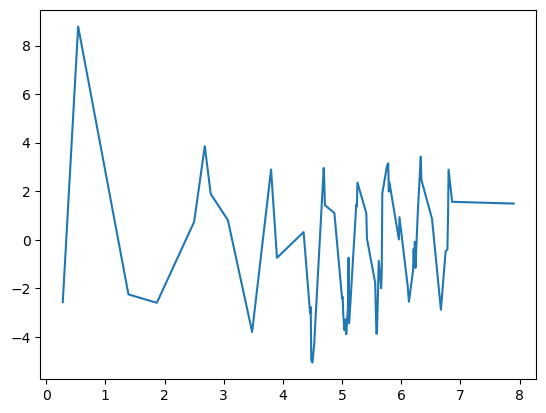

In [39]:
plt.plot(t, mu_S)

In [28]:
unique_settings  = []
mean_observables = []
std_observables  = []
for setting in np.unique(settings):
    unique_settings.append(setting)
    idx = np.where(settings==setting)[0]
    mean_observables.append(observables[idx].mean())
    std_observables.append(observables[idx].std())

unique_settings  = np.asarray(unique_settings)
mean_observables = np.asarray(mean_observables)
std_observables  = np.asarray(std_observables)

[-4.3648720547519995,
 -0.7787510901352812,
 5.701634077955021,
 6.607112570317506,
 -2.796646546596752,
 -3.7384476898541714,
 6.320191080768885,
 0.4372596762246692,
 1.7024850367600375,
 1.9023610181477002,
 -2.657808598556777,
 3.4845190028750403,
 -2.274000895491321,
 -4.738894133092505,
 -2.2129610330957608,
 -0.7656116378148212,
 3.116548569236237,
 2.810496937410505,
 0.7915091726566836,
 -1.3076959937827173,
 -3.6958892202732403,
 -4.436668940428499,
 -3.7808601904939447,
 -3.0421740053853155,
 -1.6991123643706776,
 -0.850532703688895,
 -1.39917283264774,
 4.291527668810335,
 4.020882729805977,
 2.1046442689797513,
 -0.15456024808649693,
 -2.6357682402250058,
 -2.284559042853239,
 -3.677548130229617,
 -1.5148808049570222,
 -0.9868694812117486,
 0.652584099302215,
 1.3636892205779725,
 1.0316119196618787,
 1.69593532342525,
 3.405718840299273,
 3.2199802547834544,
 1.5015836781569813,
 -1.052001508873799,
 -0.40738673115785057,
 -0.4511351321347572,
 -3.751444997199499,
 1.6301

In [57]:
param_prior = {
    'J': {'mu': -1.5, 'sigma': 0.5, 'bounds': [-5, 0.]},
    'D': {'mu': -0.5, 'sigma': 0.25, 'bounds': [-2.0, 0.]},
    'gamma': {'mu': 0.5, 'sigma': 0.25, 'bounds': [0., None]},
}
times = torch.arange(0,10,0.01)

In [61]:
idx = np.random.choice(len(X_val))
x_val = X_val[idx]
y_val = Y_val[idx]

omega_val, inten_val = [], []
for i in range(2):
    _omega, _inten = lorentzian(y_val[i], 0.25, y_val[i+2], minimum=0.)
    omega_val.append(_omega); inten_val.append(_inten)
omega_val = torch.cat(omega_val); inten_val = torch.cat(inten_val)
inten_val = inten_val / inten_val.sum() * y_val[-2:].sum()
true_pars = x_val.cpu().numpy().tolist() + [0.25,]


true_S = batch_spec_to_Sqt(omega_val, inten_val, times).sum(dim=1).squeeze().detach().cpu().numpy()
func_S = interp1d(times.cpu().numpy(), true_S)
sigma_noise = 0.1 * true_S[0]
def measure_t(t, sigma_noise=0.):
    if isinstance(t, (float,int)):
        t = np.array([t,]).astype('float64')
    elif isinstance(t, torch.Tensor):
        t = t.detach().cpu().numpy()
    return func_S(t) + sigma_noise * np.random.randn(*t.shape)

In [62]:
settings_measurements = []
mu_measurements = []
sigma_measurements = []
S0 = np.asarray([measure_t(0) for i in range(100)]).mean()

bayes = BayesianInference(model_spec, param_prior, (times,), scale_factor=S0)


In [63]:

print(x_val)
print(y_val)
print(bayes.model(x_val))

tensor([-2.5760, -0.7125])
tensor([ 7.1198, 18.3559,  5.2199,  3.7801])
tensor([ 7.1028, 18.3771,  5.2114,  3.7799], grad_fn=<SqueezeBackward3>)


In [71]:
bayes.init_parameters()
next_id, next_setting = bayes.propose_next_setting()
next_measurement = np.asarray([measure_t(next_setting[0], sigma_noise) for i in range(10)])
mu_next_measurement, sigma_next_measurement = next_measurement.mean(), next_measurement.std()

bayes.update_store_measurements(next_id, next_setting, mu_next_measurement, sigma_next_measurement)

for i in range(100):
    loss_hist = bayes.grad_desc_on_measurement(
        bayes.measured_settings, bayes.measured_mus, bayes.measured_sigmas, maxiter=500, ret_loss_hist=True, 
        replace_worst_with_mean=True)

    next_id, next_setting = bayes.propose_next_setting()
    next_measurement = np.asarray([measure_t(next_setting[0], sigma_noise) for i in range(10)])
    mu_next_measurement, sigma_next_measurement = next_measurement.mean(), next_measurement.std()

    bayes.update_store_measurements(next_id, next_setting, mu_next_measurement, sigma_next_measurement)

    
    print(next_setting, loss_hist[-1])
    if loss_hist[-1] < 1:
        break

(tensor(2.7100),) 5.297163159093407
(tensor(2.3600),) 5.358301605928782
(tensor(2.5500),) 5.451571257651876
(tensor(1.2900),) 5.437211902712025
(tensor(1.5000),) 5.506413046027248
(tensor(2.3000),) 5.667463516090113
(tensor(2.3200),) 5.708723312837386
(tensor(3.1500),) 5.747881758174357
(tensor(2.3500),) 5.723687318522081
(tensor(1.5500),) 5.782018110872418
(tensor(1.5600),) 5.8816481820070114
(tensor(1.6300),) 5.93351689627246
(tensor(1.1900),) 5.935596184975149
(tensor(1.3200),) 5.901682844193062
(tensor(1.5200),) 5.9525040788422485
(tensor(1.6000),) 5.992362169293319
(tensor(1.2600),) 6.032881620832966
(tensor(1.7700),) 6.094360564888413
(tensor(1.2100),) 6.14843686503009
(tensor(1.1800),) 6.147130444229208
(tensor(1.5700),) 6.106439830375546
(tensor(1.7800),) 6.126099788160798
(tensor(2.0700),) 6.228860684023633
(tensor(2.3700),) 6.266448973332486
(tensor(1.5300),) 6.250156336272667
(tensor(1.1700),) 6.25452061853065
(tensor(0.7300),) 6.204062486452936
(tensor(1.9200),) 6.213182119

KeyboardInterrupt: 

(array([  2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 498.]),
 array([1.45320764, 1.45320764, 1.45320764, 1.45320764, 1.45320764,
        1.45320764, 1.45320764, 1.45320764, 1.45320764, 1.45320764,
        1.45320764]),
 <BarContainer object of 10 artists>)

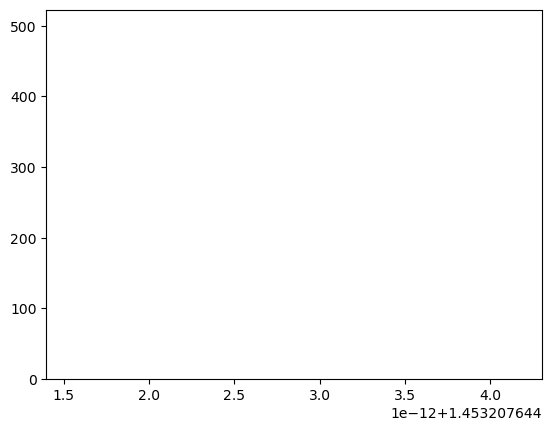

In [72]:
# bayes.init_parameters()

plt.hist(bayes.gamma.data.squeeze())

In [73]:
# bayes.J.data[:] = bayes.J.data / bayes.J.data * x_val[0]
# bayes.D.data[:] = bayes.D.data / bayes.D.data * x_val[1]
# bayes.gamma.data[:] = torch.ones_like(bayes.gamma.data) * 0.25
mu, _ = bayes.evaluate_likelihood_over_all_settings()

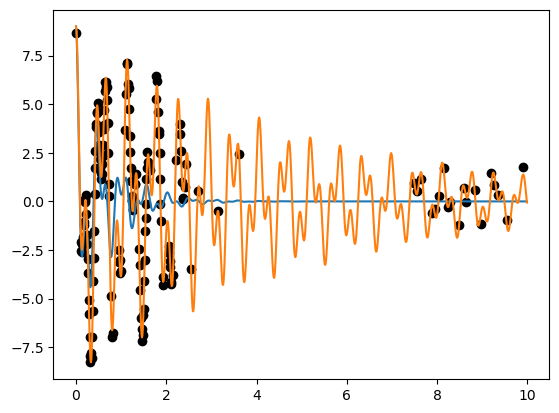

In [74]:
plt.plot(times, bayes.y_likelihood.mean(dim=0))
# plt.plot(times, mu, '-')
plt.scatter(bayes.measured_settings, bayes.measured_mus_lst, c='k')
plt.plot(times, measure_t(times))